In [95]:
# Import library

import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns
import cv2

plt.style.use("ggplot")
import timm
import torchsummary

In [10]:
import torch, random, numpy as np


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

In [11]:
CLASS = ['real', 'fake']

## Dataloader

In [97]:
class DeepFakeImageDataset(Dataset):
    def __init__(self, data_path, transform):
        super().__init__()
        self.data = []
        self.transform = transform
        for label in os.listdir(data_path):
            label_path = os.path.join(data_path, label)
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        try:
            transformed_image = self.transform(image=original_image)["image"]
        except:
            transformed_image = self.transform(original_image)

        y = CLASS.index(label)
        return original_image, transformed_image, torch.tensor(y)

In [13]:
from pathlib import Path
current_path = Path.cwd()
parent_path = (
    current_path.parent.resolve()
)  
print(f"Parent path: {parent_path}")

Parent path: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection


In [93]:
# Define transform for ResNet
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

BATCH_SIZE = 32

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

DEVICE = get_device()
DEVICE

'mps'

In [15]:
train_path = os.path.join(parent_path, "data/images/train")
val_path = os.path.join(parent_path, "data/images/val")
train_ds = DeepFakeImageDataset(train_path, transform=transform)
val_ds = DeepFakeImageDataset(val_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
model = timm.create_model("xception", pretrained=True)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /Users/mac/.cache/torch/hub/checkpoints/xception-43020ad28.pth


## Xception Transfer Learning

In [43]:
class DeepFakeXception(nn.Module):
    def __init__(self, num_classes = 2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = timm.create_model("xception", pretrained=True)
        num_ftrs = self.model.fc.in_features
        params = list(self.model.parameters())
        for param in params:
            param.requires_grad = False # Freeze base model
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, X):
        return self.model(X)

In [38]:
def get_labels(logits):
    return torch.argmax(nn.Softmax(dim = -1)(logits), dim = 1).cpu().detach().flatten().tolist()

In [39]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [41]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training")

    for _, images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_preds = []
    all_probs_real = []

    with torch.inference_mode():
        for _, images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs_real.extend(probs[:, 1].cpu().numpy())

    avg_loss = running_loss / total_samples
    avg_acc = correct_predictions / total_samples

    f1 = f1_score(all_labels, all_preds, average="binary")

    try:
        auc = roc_auc_score(all_labels, all_probs_real)
    except ValueError:
        auc = 0.0

    return avg_loss, avg_acc, f1, auc

In [42]:
TASK_NAME = "image_classification"
LR = 1e-3
EPOCHS = 10
MODEL_NAME = "Xception"

In [45]:
model = DeepFakeXception()
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [47]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

best_acc = 0.0

In [48]:
import json


def save_experiment_json(history, filename):
    """@
    Saves the experiment history to a JSON file.
    """
    with open(filename, "w") as f:
        json.dump(history, f, indent=4)
    print(f"History saved to {filename}")


def save_checkpoint(model, optimizer, filename="checkpoint.pth"):
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(checkpoint, filename)
    print("Checkpoint saved:", filename)

In [49]:
# Add tracking
best_acc = -1
MODEL_SAVED_PATH = os.path.join(
    parent_path, f"model_checkpoints/{MODEL_NAME}_{TASK_NAME}.pth"
)

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]


[1/10] train_acc: 0.5903 - train_loss: 0.6663 - valid_acc: 0.5907 - valid_loss: 0.6674
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_image_classification.pth
	- [current best] epoch: 1 - acc: 0.5907



Evaluating: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]


[2/10] train_acc: 0.6272 - train_loss: 0.6449 - valid_acc: 0.6045 - valid_loss: 0.6567
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_image_classification.pth
	- [current best] epoch: 2 - acc: 0.6045



Evaluating: 100%|██████████| 125/125 [00:46<00:00,  2.67it/s]


[3/10] train_acc: 0.6419 - train_loss: 0.6328 - valid_acc: 0.5995 - valid_loss: 0.6688
	- [current best] epoch: 2 - acc: 0.6045



Evaluating: 100%|██████████| 125/125 [00:43<00:00,  2.84it/s]


[4/10] train_acc: 0.6460 - train_loss: 0.6267 - valid_acc: 0.6145 - valid_loss: 0.6677
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_image_classification.pth
	- [current best] epoch: 4 - acc: 0.6145



Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


[5/10] train_acc: 0.6550 - train_loss: 0.6227 - valid_acc: 0.6222 - valid_loss: 0.6545
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_image_classification.pth
	- [current best] epoch: 5 - acc: 0.6222



Evaluating: 100%|██████████| 125/125 [00:37<00:00,  3.37it/s]


[6/10] train_acc: 0.6598 - train_loss: 0.6187 - valid_acc: 0.5797 - valid_loss: 0.7050
	- [current best] epoch: 5 - acc: 0.6222



Evaluating: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


[7/10] train_acc: 0.6593 - train_loss: 0.6158 - valid_acc: 0.6170 - valid_loss: 0.6604
	- [current best] epoch: 5 - acc: 0.6222



Evaluating: 100%|██████████| 125/125 [3:36:55<00:00, 104.12s/it]   


[8/10] train_acc: 0.6637 - train_loss: 0.6135 - valid_acc: 0.5845 - valid_loss: 0.7241
	- [current best] epoch: 5 - acc: 0.6222



Evaluating: 100%|██████████| 125/125 [00:36<00:00,  3.44it/s]


[9/10] train_acc: 0.6666 - train_loss: 0.6087 - valid_acc: 0.6025 - valid_loss: 0.6672
	- [current best] epoch: 5 - acc: 0.6222



Evaluating: 100%|██████████| 125/125 [00:37<00:00,  3.33it/s]

[10/10] train_acc: 0.6675 - train_loss: 0.6101 - valid_acc: 0.6140 - valid_loss: 0.6776
	- [current best] epoch: 5 - acc: 0.6222



In [87]:
def plot_history(history, title, save_path, start_finetuned_epoch=None):
    epochs = range(1, len(history["train_losses"]) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plt.suptitle(title)

    ax[0].plot(
        epochs,
        history["train_losses"],
        label="training loss",
        marker="*",
        color="green",
    )
    ax[0].plot(
        epochs, history["val_losses"], label="validation loss", marker="s", color="blue"
    )
    ax[0].set_title("Loss Curve")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    if start_finetuned_epoch is not None:
        ax[0].axvline(
            x=start_finetuned_epoch,
            color="red",
            linestyle="--",
            label="Start Fine-Tuning",
        )
    ax[0].legend()
    ax[0].grid(True, linestyle="--", alpha=0.7)

    ax[1].plot(
        epochs,
        history["train_accuracy"],
        label="training accuracy",
        marker="*",
        color="green",
    )
    ax[1].plot(
        epochs,
        history["val_accuracy"],
        label="validation accuracy",
        marker="s",
        color="blue",
    )
    ax[1].set_title("Accuracy Curve")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    if start_finetuned_epoch is not None:
        ax[1].axvline(
            x=start_finetuned_epoch,
            color="red",
            linestyle="--",
            label="Start Fine-Tuning",
        )
    ax[1].grid(True, linestyle="--", alpha=0.7)

    plt.savefig(save_path)
    plt.tight_layout()
    plt.show()

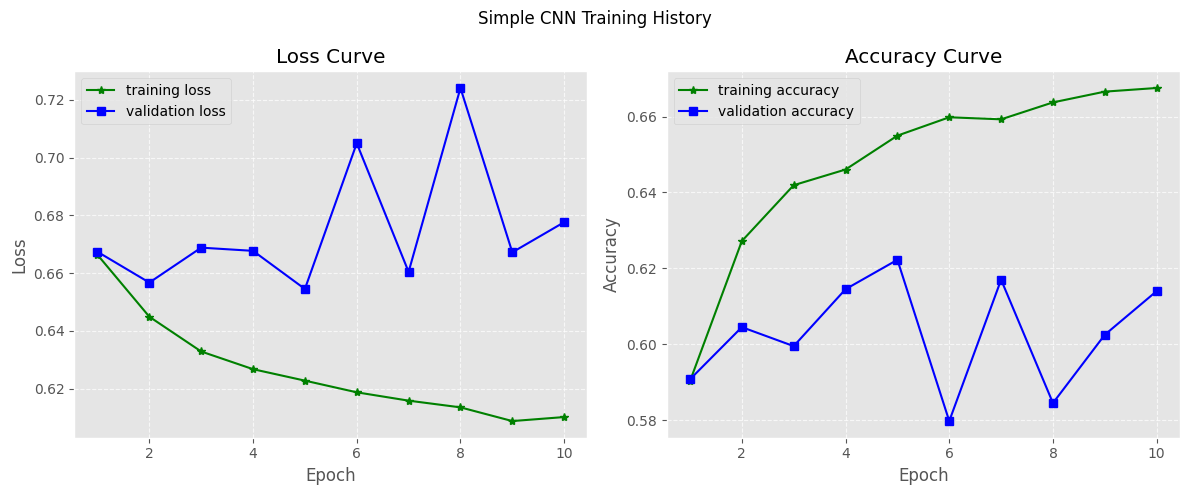

In [51]:



save_path = f"{parent_path}/result/{MODEL_NAME}_{TASK_NAME}.png"
plot_history(history,"Resnet18 Training History", save_path=save_path)

In [ ]:
# Evaluate the model with f1-score and confusion matrix

torch.Size([32, 256, 256, 3])


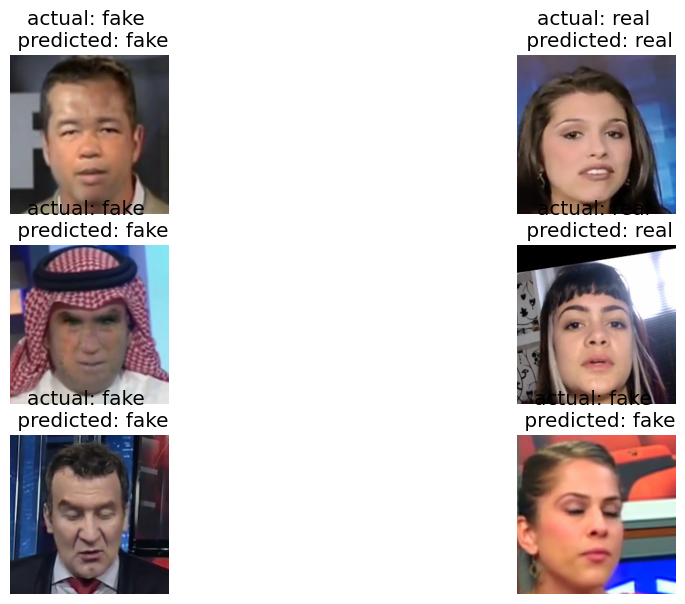

In [52]:
import matplotlib.pyplot as plt
def visualize_model_prediction(model, dataloader,  num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 7))

    with torch.no_grad():
        for i, (originals, inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            print(originals.shape)
            outputs = model(inputs)
            preds = get_labels(outputs)

            # Get random index
            random_indices = np.random.choice(np.arange(inputs.size()[0]), size = num_images, replace=False)

            for j in random_indices:
                images_so_far += 1
                plt.subplot(num_images // 2, 2, images_so_far)
                plt.axis('off')
                plt.title(f"actual: {CLASS[labels[j].item()]} \n predicted: {CLASS[preds[j]]}")
                plt.tight_layout()
                plt.imshow(originals.cpu().data[j])

                if images_so_far == num_images:
                    return
visualize_model_prediction(model, val_loader, num_images=6)

## Evaluation

In [53]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)

In [54]:

def get_target_pred(model, data_loader):
    model.eval()
    targets, preds = [], []
    with torch.inference_mode():
        for _, inputs, labels in tqdm(data_loader, desc="Eval"):
            inputs = inputs.to(device=DEVICE)
            labels = labels.to(device=DEVICE)
            logits = model(inputs)
            targets.extend(labels.cpu().detach().tolist())
            preds.extend(get_labels(logits))
    return targets, preds 

targets, preds = get_target_pred(model, val_loader)

Eval: 100%|██████████| 125/125 [00:45<00:00,  2.76it/s]


In [55]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54      2000
           1       0.59      0.77      0.67      2000

    accuracy                           0.61      4000
   macro avg       0.63      0.61      0.60      4000
weighted avg       0.63      0.61      0.60      4000



In [124]:
def plot_confusion_matrix_heatmap(
    y_true, y_pred, title, saved_path, class_names=["Real", "Fake"]
):
    """
    Generates and plots a confusion matrix heatmap.
    """
    import matplotlib.pyplot as plt

    plt.style.use("ggplot")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.savefig(saved_path)
    plt.show()

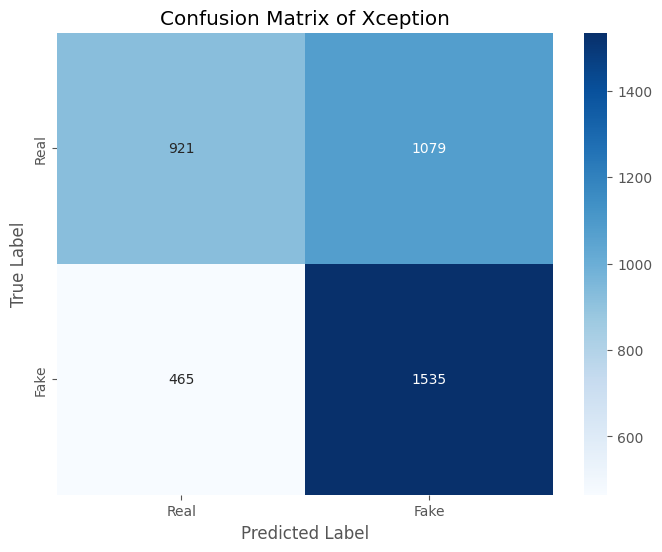

In [ ]:

saved_path = f"../result/{MODEL_NAME}_{TASK_NAME}_cfm.png"
plot_confusion_matrix_heatmap(targets, preds, f"Confusion Matrix of {MODEL_NAME}", saved_path=save_path, class_names=["Real", "Fake"])

In [82]:
json_path = os.path.join(parent_path, f"result/{MODEL_NAME}_{TASK_NAME}_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/result/Xception_image_classification_history.json


## Finetuning Xception

In [65]:
model

DeepFakeXception(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(in

In [70]:
# Get number of blocks
blocks = list(model.model.named_children())
print("Number of blocks: ", len(blocks))

Number of blocks:  26


In [80]:
# Start unfreezing from block 10
start_block = 'block10'
start_index = 0
for i, (name, _) in enumerate(blocks):
    if name == start_block:
        start_index = i
        break
print("Start unfreezing block from index: ", start_index)


for name, module in blocks[start_index:]:
    print("Unfreeze block: ", name)
    for param in module.parameters():
        param.requires_grad = True

torchsummary.summary(model.to('cpu'), (3, 224, 224))

Start unfreezing block from index:  15
Unfreeze block:  block10
Unfreeze block:  block11
Unfreeze block:  block12
Unfreeze block:  conv3
Unfreeze block:  bn3
Unfreeze block:  act3
Unfreeze block:  conv4
Unfreeze block:  bn4
Unfreeze block:  act4
Unfreeze block:  global_pool
Unfreeze block:  fc
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]             576
            Conv2d-8        [-1, 128, 109, 109]           8,192
   SeparableConv2d-9        [-1, 128, 109, 109]               0


In [85]:
NEW_LR = 1e-5  # Small updates
model = model.to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=NEW_LR)
criterion = nn.CrossEntropyLoss()

In [86]:
NUM_FINETUNED_EPOCHS = 10

model_saved_path = os.path.join(
    parent_path, f"model_checkpoints/{MODEL_NAME}_finetuned_{TASK_NAME}.pth"
)

TOTAL_EPOCHS = EPOCHS + NUM_FINETUNED_EPOCHS
print(f"START FINETUNING {MODEL_NAME} AT EPOCH = {EPOCHS + 1}")
for epoch in range(EPOCHS, TOTAL_EPOCHS, 1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_saved_path)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = model_saved_path

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

START FINETUNING Xception AT EPOCH = 11


Evaluating: 100%|██████████| 125/125 [00:38<00:00,  3.26it/s]


[11/20] train_acc: 0.7145 - train_loss: 0.5531 - valid_acc: 0.6562 - valid_loss: 0.6360
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_finetuned_image_classification.pth
	- [current best] epoch: 11 - acc: 0.6562



Evaluating: 100%|██████████| 125/125 [00:37<00:00,  3.37it/s]


[12/20] train_acc: 0.7977 - train_loss: 0.4373 - valid_acc: 0.6647 - valid_loss: 0.7093
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_finetuned_image_classification.pth
	- [current best] epoch: 12 - acc: 0.6647



Evaluating: 100%|██████████| 125/125 [00:40<00:00,  3.09it/s]


[13/20] train_acc: 0.8527 - train_loss: 0.3471 - valid_acc: 0.6880 - valid_loss: 0.6824
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_finetuned_image_classification.pth
	- [current best] epoch: 13 - acc: 0.6880



Evaluating: 100%|██████████| 125/125 [00:36<00:00,  3.39it/s]


[14/20] train_acc: 0.8891 - train_loss: 0.2782 - valid_acc: 0.6897 - valid_loss: 0.6958
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_finetuned_image_classification.pth
	- [current best] epoch: 14 - acc: 0.6897



Evaluating: 100%|██████████| 125/125 [00:36<00:00,  3.39it/s]


[15/20] train_acc: 0.9185 - train_loss: 0.2226 - valid_acc: 0.7060 - valid_loss: 0.6934
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_finetuned_image_classification.pth
	- [current best] epoch: 15 - acc: 0.7060



Evaluating: 100%|██████████| 125/125 [00:37<00:00,  3.37it/s]


[16/20] train_acc: 0.9375 - train_loss: 0.1811 - valid_acc: 0.7070 - valid_loss: 0.8156
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_finetuned_image_classification.pth
	- [current best] epoch: 16 - acc: 0.7070



Evaluating: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[17/20] train_acc: 0.9482 - train_loss: 0.1493 - valid_acc: 0.7087 - valid_loss: 0.7831
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_finetuned_image_classification.pth
	- [current best] epoch: 17 - acc: 0.7087



Evaluating: 100%|██████████| 125/125 [00:39<00:00,  3.19it/s]


[18/20] train_acc: 0.9594 - train_loss: 0.1236 - valid_acc: 0.7023 - valid_loss: 0.8506
	- [current best] epoch: 17 - acc: 0.7087



Evaluating: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


[19/20] train_acc: 0.9718 - train_loss: 0.0958 - valid_acc: 0.6993 - valid_loss: 0.9772
	- [current best] epoch: 17 - acc: 0.7087



Evaluating: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]

[20/20] train_acc: 0.9768 - train_loss: 0.0801 - valid_acc: 0.7047 - valid_loss: 0.9068
	- [current best] epoch: 17 - acc: 0.7087



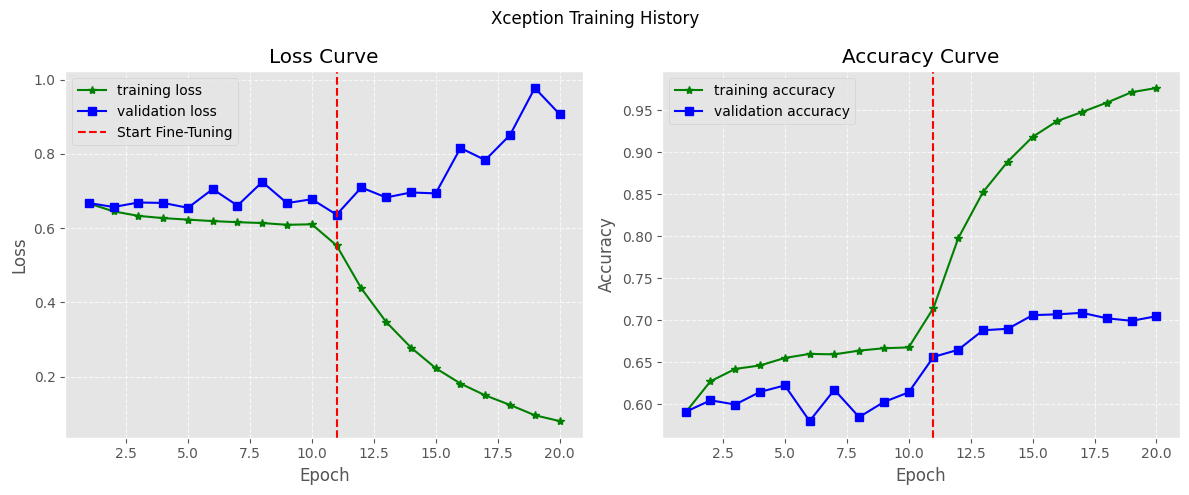

In [89]:
save_path = f"{parent_path}/result/{MODEL_NAME}_{TASK_NAME}.png"
plot_history(history, "Xception Training History", save_path=save_path, start_finetuned_epoch=EPOCHS+1)

In [101]:
json_path = os.path.join(parent_path, f"results/{MODEL_NAME}_(finetuned_no_data_augment)_{TASK_NAME}_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/Xception_(finetuned_no_data_augment)_image_classification_history.json


## Data augmentation with Label smoothing

In [98]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Define the training augmentation pipeline
train_transforms = A.Compose(
    [
        # --- SPATIAL AUGMENTATION (Standard) ---
        A.HorizontalFlip(p=0.5),  # DeepFakes should be detectable even if flipped
        # # Rotate slightly. Don't rotate too much or you lose the "upright face" context
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        # # 2. Add Noise: Destroys specific camera/generator noise fingerprints
        A.OneOf(
            [
                A.GaussNoise(p=0.5),
                A.ISONoise(color_shift=(0.01, 0.02), intensity=(0.4, 0.5), p=0.5),
            ],
            p=0.5,
        ),
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# Validation should NOT have noise/dropout, only Resize/Normalize
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [99]:
train_ds = DeepFakeImageDataset(train_path, transform=train_transforms)
val_ds = DeepFakeImageDataset(val_path, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [103]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

best_acc = 0.0

In [107]:
TASK_NAME = "image_classification"
LR = 1e-4
EPOCHS = 10
MODEL_NAME = "Xception"

In [104]:
model = DeepFakeXception()
torchsummary.summary(model, (3, 224, 224), batch_size=32)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 111, 111]             864
       BatchNorm2d-2         [32, 32, 111, 111]              64
              ReLU-3         [32, 32, 111, 111]               0
            Conv2d-4         [32, 64, 109, 109]          18,432
       BatchNorm2d-5         [32, 64, 109, 109]             128
              ReLU-6         [32, 64, 109, 109]               0
            Conv2d-7         [32, 64, 109, 109]             576
            Conv2d-8        [32, 128, 109, 109]           8,192
   SeparableConv2d-9        [32, 128, 109, 109]               0
      BatchNorm2d-10        [32, 128, 109, 109]             256
             ReLU-11        [32, 128, 109, 109]               0
           Conv2d-12        [32, 128, 109, 109]           1,152
           Conv2d-13        [32, 128, 109, 109]          16,384
  SeparableConv2d-14        [32, 128, 1

In [105]:
model = model.to(device=DEVICE)
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.Adam(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [108]:
MODEL_SAVED_PATH = os.path.join(
    parent_path, f"model_checkpoints/{MODEL_NAME}_(data_augment)_{TASK_NAME}.pth"
)

print(f"Training model {MODEL_NAME}: LR = {LR}, EPOCHS = {EPOCHS}")

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training model Xception: LR = 0.0001, EPOCHS = 10


Evaluating: 100%|██████████| 125/125 [00:44<00:00,  2.80it/s]


[1/10] train_acc: 0.5465 - train_loss: 0.6930 - valid_acc: 0.5580 - valid_loss: 0.6833
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_(data_augment)_image_classification.pth
	- [current best] epoch: 1 - acc: 0.5580



Evaluating: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]


[2/10] train_acc: 0.5624 - train_loss: 0.6893 - valid_acc: 0.5547 - valid_loss: 0.6890
	- [current best] epoch: 1 - acc: 0.5580



Evaluating: 100%|██████████| 125/125 [00:43<00:00,  2.85it/s]


[3/10] train_acc: 0.5662 - train_loss: 0.6879 - valid_acc: 0.5590 - valid_loss: 0.6828
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_(data_augment)_image_classification.pth
	- [current best] epoch: 3 - acc: 0.5590



Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


[4/10] train_acc: 0.5647 - train_loss: 0.6866 - valid_acc: 0.5537 - valid_loss: 0.6875
	- [current best] epoch: 3 - acc: 0.5590



Evaluating: 100%|██████████| 125/125 [00:36<00:00,  3.39it/s]


[5/10] train_acc: 0.5637 - train_loss: 0.6861 - valid_acc: 0.5565 - valid_loss: 0.6896
	- [current best] epoch: 3 - acc: 0.5590



Evaluating: 100%|██████████| 125/125 [00:32<00:00,  3.81it/s]


[6/10] train_acc: 0.5656 - train_loss: 0.6872 - valid_acc: 0.5610 - valid_loss: 0.6808
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_(data_augment)_image_classification.pth
	- [current best] epoch: 6 - acc: 0.5610



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.68it/s]


[7/10] train_acc: 0.5648 - train_loss: 0.6876 - valid_acc: 0.5620 - valid_loss: 0.6795
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_(data_augment)_image_classification.pth
	- [current best] epoch: 7 - acc: 0.5620



Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.76it/s]


[8/10] train_acc: 0.5664 - train_loss: 0.6847 - valid_acc: 0.5810 - valid_loss: 0.6766
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_(data_augment)_image_classification.pth
	- [current best] epoch: 8 - acc: 0.5810



Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


[9/10] train_acc: 0.5641 - train_loss: 0.6849 - valid_acc: 0.5755 - valid_loss: 0.6779
	- [current best] epoch: 8 - acc: 0.5810



Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.76it/s]

[10/10] train_acc: 0.5571 - train_loss: 0.6887 - valid_acc: 0.5617 - valid_loss: 0.6830
	- [current best] epoch: 8 - acc: 0.5810



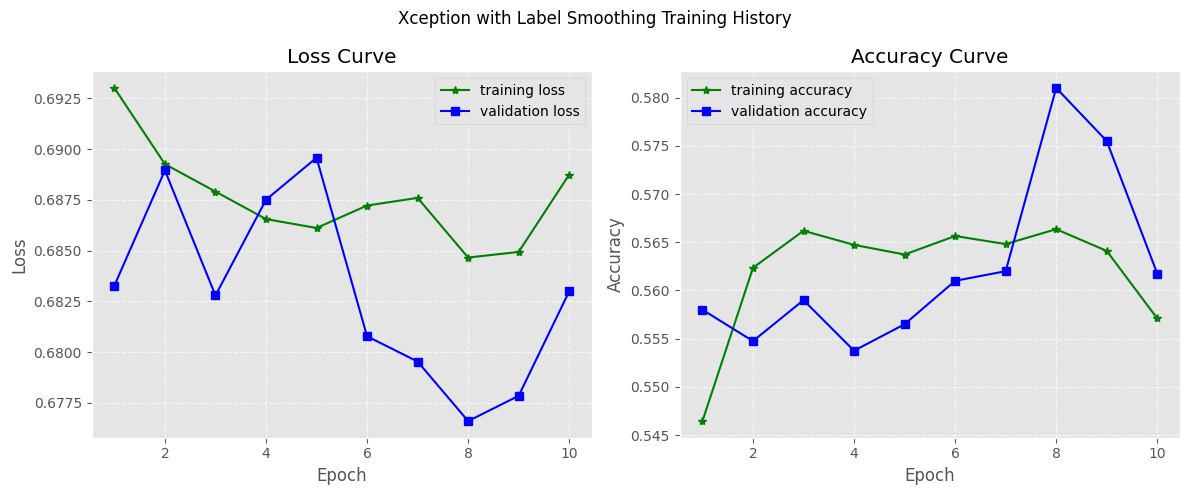

In [111]:
save_path = f"{parent_path}/results/{MODEL_NAME}_with_reg_{TASK_NAME}.png"
plot_history(
    history,
    "Xception with Label Smoothing Training History",
    save_path=save_path,
)

In [113]:
# Start unfreezing from block 4
blocks = list(model.model.named_children())
start_block = "block4"
start_index = 0
for i, (name, _) in enumerate(blocks):
    if name == start_block:
        start_index = i
        break
print("Start unfreezing block from index: ", start_index)


for name, module in blocks[start_index:]:
    print("Unfreeze block: ", name)
    for param in module.parameters():
        param.requires_grad = True

torchsummary.summary(model.to("cpu"), (3, 224, 224))

Start unfreezing block from index:  9
Unfreeze block:  block4
Unfreeze block:  block5
Unfreeze block:  block6
Unfreeze block:  block7
Unfreeze block:  block8
Unfreeze block:  block9
Unfreeze block:  block10
Unfreeze block:  block11
Unfreeze block:  block12
Unfreeze block:  conv3
Unfreeze block:  bn3
Unfreeze block:  act3
Unfreeze block:  conv4
Unfreeze block:  bn4
Unfreeze block:  act4
Unfreeze block:  global_pool
Unfreeze block:  fc
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]  

In [114]:
NEW_LR = 1e-5  # Small updates
model = model.to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=NEW_LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [115]:
NUM_FINETUNED_EPOCHS = 10

model_saved_path = os.path.join(
    parent_path, f"model_checkpoints/{MODEL_NAME}_with_reg_finetuned_{TASK_NAME}.pth"
)

TOTAL_EPOCHS = EPOCHS + NUM_FINETUNED_EPOCHS
print(f"START FINETUNING {MODEL_NAME} AT EPOCH = {EPOCHS + 1}")
for epoch in range(EPOCHS, TOTAL_EPOCHS, 1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_saved_path)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = model_saved_path

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

START FINETUNING Xception AT EPOCH = 11


Evaluating: 100%|██████████| 125/125 [00:31<00:00,  4.00it/s]


[11/20] train_acc: 0.6055 - train_loss: 0.6644 - valid_acc: 0.6365 - valid_loss: 0.6432
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 11 - acc: 0.6365



Evaluating: 100%|██████████| 125/125 [00:32<00:00,  3.83it/s]


[12/20] train_acc: 0.6507 - train_loss: 0.6320 - valid_acc: 0.6683 - valid_loss: 0.6192
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 12 - acc: 0.6683



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.71it/s]


[13/20] train_acc: 0.6825 - train_loss: 0.6002 - valid_acc: 0.7137 - valid_loss: 0.5907
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 13 - acc: 0.7137



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.72it/s]


[14/20] train_acc: 0.7167 - train_loss: 0.5716 - valid_acc: 0.7372 - valid_loss: 0.5817
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 14 - acc: 0.7372



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.71it/s]


[15/20] train_acc: 0.7335 - train_loss: 0.5487 - valid_acc: 0.7445 - valid_loss: 0.5701
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 15 - acc: 0.7445



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.72it/s]


[16/20] train_acc: 0.7531 - train_loss: 0.5293 - valid_acc: 0.7532 - valid_loss: 0.5796
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 16 - acc: 0.7532



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.72it/s]


[17/20] train_acc: 0.7647 - train_loss: 0.5149 - valid_acc: 0.7632 - valid_loss: 0.5764
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 17 - acc: 0.7632



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.72it/s]


[18/20] train_acc: 0.7764 - train_loss: 0.4979 - valid_acc: 0.7782 - valid_loss: 0.5594
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 18 - acc: 0.7782



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.72it/s]


[19/20] train_acc: 0.7836 - train_loss: 0.4930 - valid_acc: 0.7690 - valid_loss: 0.5861
	- [current best] epoch: 18 - acc: 0.7782



Evaluating: 100%|██████████| 125/125 [00:34<00:00,  3.64it/s]


[20/20] train_acc: 0.7946 - train_loss: 0.4805 - valid_acc: 0.7973 - valid_loss: 0.5456
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 20 - acc: 0.7973



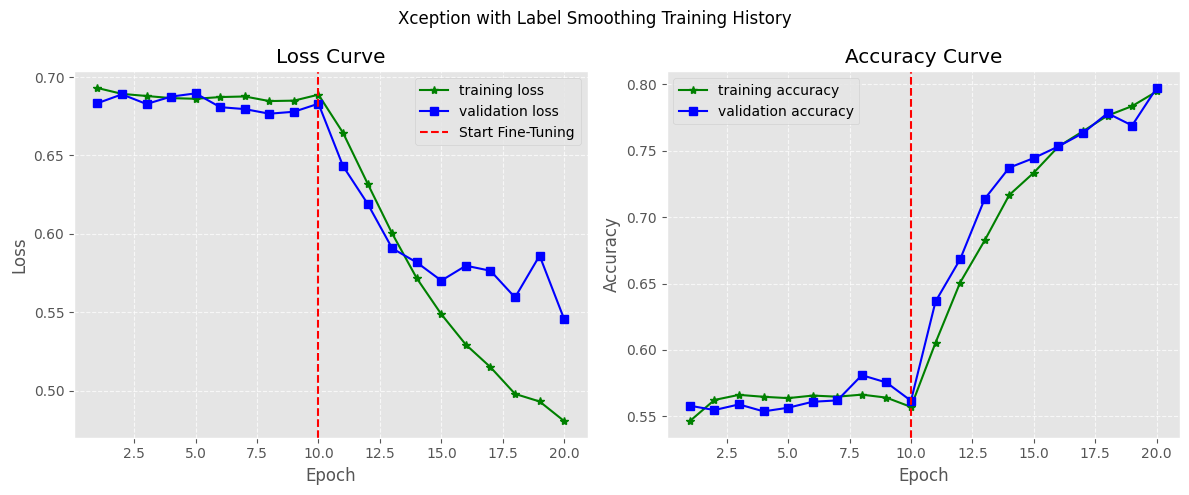

In [116]:
save_path = f"{parent_path}/results/{MODEL_NAME}_with_reg_finetuned_{TASK_NAME}.png"
plot_history(
    history,
    "Xception with Label Smoothing Training History",
    save_path=save_path,
    start_finetuned_epoch=EPOCHS
)

In [117]:
# Fine tune with 10 more epochs
NUM_FINETUNED_EPOCHS_STAGE_3 = 10

FINAL_TOTAL_EPOCHS = TOTAL_EPOCHS + NUM_FINETUNED_EPOCHS_STAGE_3


for epoch in range(TOTAL_EPOCHS, FINAL_TOTAL_EPOCHS, 1):
    # Traina
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{FINAL_TOTAL_EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_saved_path)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = model_saved_path

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Evaluating: 100%|██████████| 125/125 [00:34<00:00,  3.61it/s]


[21/30] train_acc: 0.8073 - train_loss: 0.4687 - valid_acc: 0.7973 - valid_loss: 0.5508
	- [current best] epoch: 20 - acc: 0.7973



Evaluating: 100%|██████████| 125/125 [00:34<00:00,  3.66it/s]


[22/30] train_acc: 0.8113 - train_loss: 0.4594 - valid_acc: 0.8035 - valid_loss: 0.5384
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 22 - acc: 0.8035



Evaluating: 100%|██████████| 125/125 [00:40<00:00,  3.12it/s]


[23/30] train_acc: 0.8177 - train_loss: 0.4556 - valid_acc: 0.8057 - valid_loss: 0.5367
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 23 - acc: 0.8057



Evaluating: 100%|██████████| 125/125 [00:38<00:00,  3.21it/s]


[24/30] train_acc: 0.8204 - train_loss: 0.4495 - valid_acc: 0.7955 - valid_loss: 0.5521
	- [current best] epoch: 23 - acc: 0.8057



Evaluating: 100%|██████████| 125/125 [00:40<00:00,  3.10it/s]


[25/30] train_acc: 0.8223 - train_loss: 0.4485 - valid_acc: 0.7850 - valid_loss: 0.5590
	- [current best] epoch: 23 - acc: 0.8057



Evaluating: 100%|██████████| 125/125 [00:33<00:00,  3.76it/s]


[26/30] train_acc: 0.8260 - train_loss: 0.4435 - valid_acc: 0.7285 - valid_loss: 0.6820
	- [current best] epoch: 23 - acc: 0.8057



Evaluating: 100%|██████████| 125/125 [00:48<00:00,  2.59it/s]


[27/30] train_acc: 0.8310 - train_loss: 0.4353 - valid_acc: 0.8200 - valid_loss: 0.5137
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_with_reg_finetuned_image_classification.pth
	- [current best] epoch: 27 - acc: 0.8200



Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]


[28/30] train_acc: 0.8357 - train_loss: 0.4323 - valid_acc: 0.8057 - valid_loss: 0.4960
	- [current best] epoch: 27 - acc: 0.8200



Evaluating: 100%|██████████| 125/125 [00:43<00:00,  2.85it/s]


[29/30] train_acc: 0.8369 - train_loss: 0.4295 - valid_acc: 0.8083 - valid_loss: 0.5338
	- [current best] epoch: 27 - acc: 0.8200



Evaluating: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]

[30/30] train_acc: 0.8402 - train_loss: 0.4256 - valid_acc: 0.8090 - valid_loss: 0.5252
	- [current best] epoch: 27 - acc: 0.8200



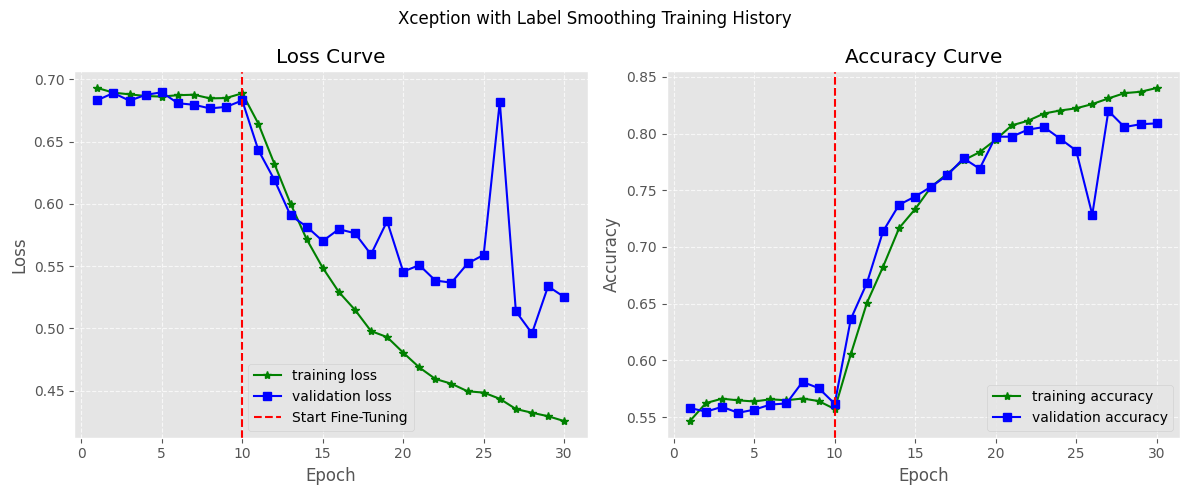

In [118]:
save_path = f"{parent_path}/results/{MODEL_NAME}_with_reg_finetuned_{TASK_NAME}.png"
plot_history(
    history,
    "Xception with Label Smoothing Training History",
    save_path=save_path,
    start_finetuned_epoch=EPOCHS,
)

In [120]:
json_path = os.path.join(
    parent_path,
    f"results/{MODEL_NAME}_(finetuned)_data_augment_label_smoothing_{TASK_NAME}_history.json",
)
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/Xception_(finetuned)_data_augment_label_smoothing_image_classification_history.json


In [121]:
# Load the best state again
checkpoint = torch.load(model_saved_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [122]:
targets, preds = get_target_pred(model, val_loader)

Eval: 100%|██████████| 125/125 [00:36<00:00,  3.43it/s]


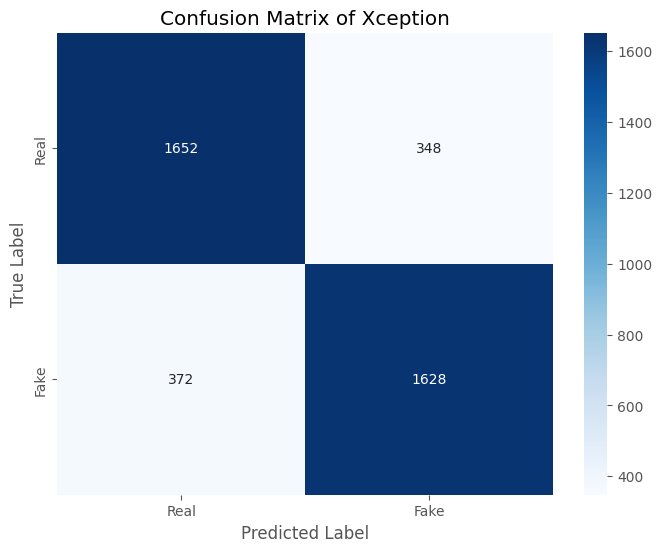

In [127]:
saved_path = f"../results/{MODEL_NAME}_(finetuned)_data_augment_label_smoothing_{TASK_NAME}_cfm.png"
plot_confusion_matrix_heatmap(
    targets,
    preds,
    f"Confusion Matrix of {MODEL_NAME}",
    saved_path=saved_path,
    class_names=["Real", "Fake"],
)